# Melodic Exploration of Single Recording Pitch Contour
March 2021

Two approaches to automated characteristic melodic pattern discovery in pitch tracks of Indian Art Music using performances from the Carnatic Saraga Collection as downloaded via MIRDATA - https://github.com/mir-dataset-loaders/mirdata

In [285]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append('../')

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#matplotlib.use('TkAgg')

from src.recording.obj import Recording, compute_distance_matrix, cluster_dist_matrix
from src.visualisation import plot_all_sequences, double_timeseries
from src.utils import detect_local_minima, get_timestamp, get_minima, search_and_cluster

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Recording

Path to recording directory in `mir_datasets/saraga_carnatic/saraga1.5_carnatic/`

In [2]:
performance_path = '/Users/thomasnuttall/mir_datasets/saraga_carnatic/saraga1.5_carnatic/Rithvik Raja at Arkay by Rithvik Raja/Chintayama Kanda/'

In [3]:
rec = Recording(performance_path)

In [22]:
print(f'Raaga: {rec.raaga}')
print(f'Arohana: {rec.arohana}')
print(f'Avorahana: {rec.arohana}')
print(f'Tonic: {rec.tonic} Hz')
print(f'Performance Length: {get_timestamp(rec.times[-1], " ")}')

Raaga: Bhairavi
Arohana: ['S', 'R2', 'G2', 'M1', 'P', 'D2', 'N2', 'S']
Avorahana: ['S', 'R2', 'G2', 'M1', 'P', 'D2', 'N2', 'S']
Tonic: 130.812783 Hz
Performance Length: 19min 42.44sec


## Melodic Exploration

Two methods of identifying repeated patterns in pitch contour time series:
- **Method 1 - Minimum in Matrix Profile + Subsequence Search**
    - Compute self-similarity Matrix Profile (MP) of pitch contour
    - Identify minimas in MP
    - Query entire pitch contour with patterns identified at minimas
    - Return those matches with a distance below some threshold
    - Number of characteristic subsequences == Number of minimas found in MP
- **Method 2 - Distance Matrix + Clustering**
    - Compute entire pitch contour self similarity matrix
    - For memory purposes, pairs of subsequences that do not match the following are discarded:
        - Proportion if non-silence above some threshold
        - Similarity within top N percent of similarities
    - DBSCAN [2] sparse clustering to identify clusters of subsequences [unsupervised]
    - DBSCAN applied again to group identical subsequences within a cluster (i.e. subsequences which are out of phase by a timestep)
    - Number of characteristic subsequences == Number of clusters returned by DBSCAN

Both rely on the Stumpy [1] matrix profiling package, using z-normalised euclidean distance for similarity.

[1] https://stumpy.readthedocs.io/en/latest/Tutorial_The_Matrix_Profile.html
[2] https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

### Method 1 - Minimum in Matrix Profile + Subsequence Search

#### 1.1 Compute Matrix Profile

In [333]:
m_secs = 7 # subsequence length in seconds
# bottom <sig_percentile> % of MP values in minimas are considered
# ...after silence filtering
sig_percentile = 10

In [310]:
mp = rec.self_matrix_profile(m=m_secs, cache=True)

First 87.0 seconds of pitch and matrix profile


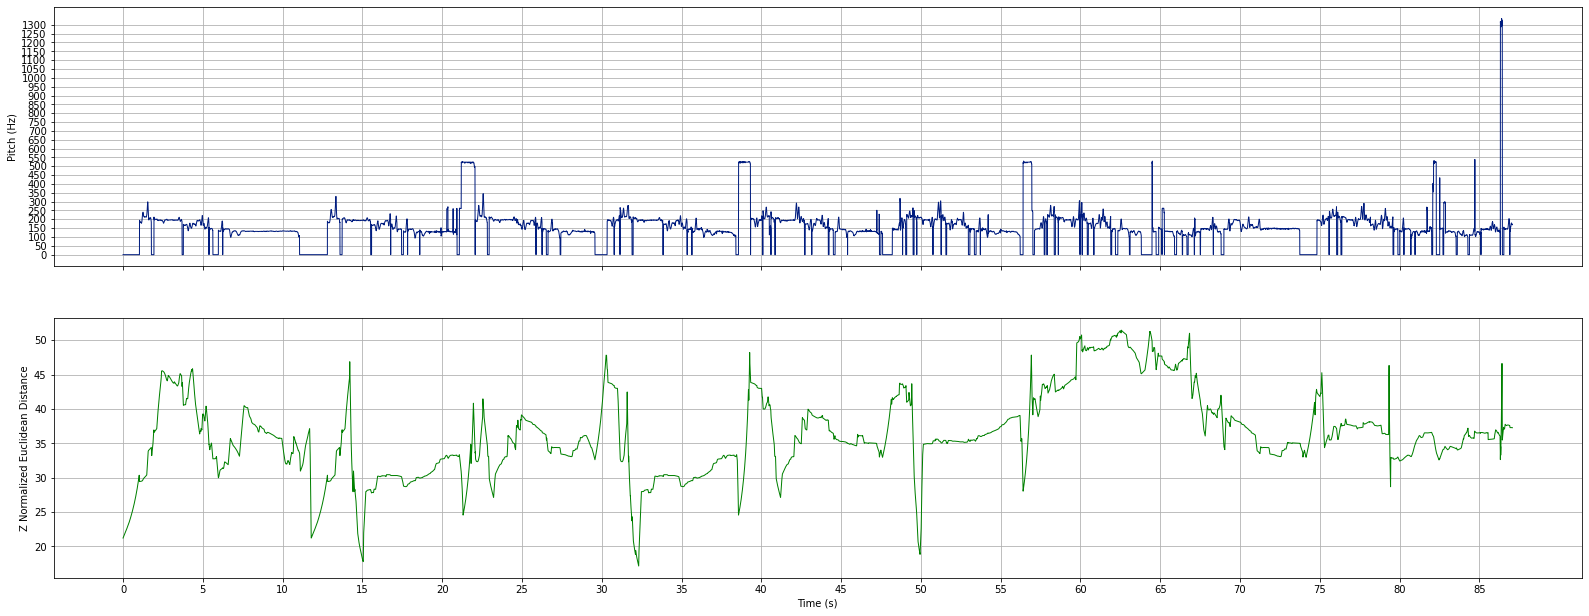

In [311]:
sam = 30000
print(f'First {sam*0.0029} seconds of pitch and matrix profile')
fig, ax = double_timeseries(
    rec.times[:sam], rec.pitch[:sam], mp[:, 0][:sam], y1label='Pitch (Hz)', 
    y2label='Z Normalized Euclidean Distance', xlabel='Time (s)')

#### 1.2 Identify Minima

In [334]:
minima = get_minima(rec, mp, m_secs, sig_percentile)
print(f'{len(minima)} minimas found (after filtering)')

10 minimas found (after filtering)


#### 1.3 Subsequence Search for Minima

In [318]:
all_seqs = search_and_cluster(minima, rec, m_secs, N=5)

#### 1.4 Plot Subsequences

In [324]:
direc = f'../plots/chintayama_kanda/MP_mining/20210304/m=7/'
plot_kwargs = {
    'yticks_dict':rec.svara_freq,
    'cents':True,
    'tonic':rec.tonic,
    'emphasize':['S'], 
    'figsize':(10,4)#,
    #'ylim':(0, 1400)
}

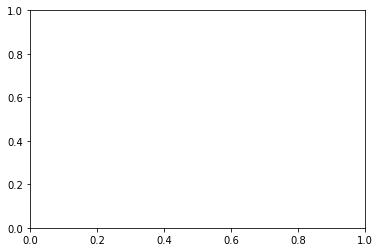

In [325]:
plot_all_sequences(rec, m_secs, all_seqs, direc, clear_dir=True, plot_kwargs=plot_kwargs)

### Method 2 - Distance Matrix + Clustering

#### 2.1 Compute Distances

<font color='red'>**Warning**</font> - very time intensive step

In [ ]:
filt_perc = 0.5 # Top <filt_perc> percentile to accept before considering
m_secs = 3 # Subsequence length in seconds
nonzero_perc = 0.50 # Percentage of subsequence to be non zero before considering
filepath = os.path.join(rec.rec_dir, 'distance_mat_generous.csv')

In [ ]:
compute_distance_matrix(rec, filt_perc, m_secs, nonzero_perc, filepath)

#### 2.2 Cluster Sequences

In [ ]:
# Load distance matrix
mat_name = 'distance_mat.csv'
filepath = os.path.join(rec.rec_dir, mat_name)
dist_data = np.genfromtxt(filepath, delimiter=',')

In [ ]:
eps = 20 # epsilon for DBSCAN in dist matrix
intra_eps = 100 # epsilon for DBSCAN on grouping neighbouring sequences
min_n_clust = 2 # minimum number of occurences of subsequence

In [ ]:
out_seq = cluster_dist_matrix(dist_data, eps, intra_eps, min_n_clust)

In [ ]:
print(f'{len(out_seq)} repeated patterns found')

#### 2.3 Plot Characteristic Subsequence Groups

In [ ]:
direc = f'../plots/chintayama_kanda/mining/{mat_name}/20210303_eps={eps}/'
plot_kwargs = {
    'yticks_dict':rec.svara_freq,
    'cents':True,
    'tonic':rec.tonic,
    'emphasize':['S'], 
    'figsize':(10,4)#,
    #'ylim':(0, 1400)
}
m_secs = 3 # Subsequence length in seconds

In [ ]:
plot_all_sequences(rec, m_secs, out_seq, direc, clear_dir=True, plot_kwargs=plot_kwargs)